In [33]:
import pandas as pd
import numpy as np
import pickle

In [34]:
input_path = 'H:\RediMinds\VCQI'
train = pd.read_csv(input_path+"\VCQI_clean_train_30_day_complications.csv")
test = pd.read_csv(input_path+"\VCQI_clean_test_30_day_complications.csv")

In [35]:
target = '30_day_COMPLICATIONS'
x_train = train.drop(labels=target, axis = 'columns').copy()
y_train = train[target].copy()
x_test = test.drop(labels=target, axis = 'columns').copy()
y_test = test[target].copy() 

In [36]:
print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

% pos labels train 0.09
% pos labels test 0.09


### One Hot Encoding Cataegorical Data

In [37]:
# ONE HOT CODE data for training

# Create dummy variables
with open (input_path+'\cat_col', 'rb') as fp:
    cat_col = pickle.load(fp)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')

one_hot_encoded_array = encoder.fit_transform(x_train[cat_col]).toarray()
column_name = encoder.get_feature_names(cat_col)
x_train_OHE =  pd.DataFrame(one_hot_encoded_array, columns= column_name)
x_train = x_train.merge(x_train_OHE, how = 'left', left_index = True, right_index =True) # create dummy variables
x_train = x_train.drop(labels = cat_col, axis = 'columns') # drop original variables

In [38]:
# Create dummy variables
one_hot_encoded_array = encoder.transform(x_test[cat_col]).toarray()
column_name = encoder.get_feature_names(cat_col)
x_test_OHE =  pd.DataFrame(one_hot_encoded_array, columns= column_name)
x_test = x_test.merge(x_test_OHE, how = 'left', left_index = True, right_index =True) # create dummy variables
x_test = x_test.drop(labels = cat_col, axis = 'columns') # drop original variables

In [39]:
print("Number of records in trainset {}".format(len(x_train)))
print("Number records in testset {}".format(len(x_test)))
print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

Number of records in trainset 1985
Number records in testset 852
% pos labels train 0.09
% pos labels test 0.09


### Defining Pipeline

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [41]:
# Pipeline for logist Classifier
sm = SMOTE(random_state=2)
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='passthrough')

# Decision Tree Classifier

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
DTC = DecisionTreeClassifier()
parameter_dist = {'DTC__max_features':['sqrt','log2',None],
                  'DTC__min_samples_leaf': [2,5,10,15,20], 
                  'DTC__class_weight' :['balanced'], 
                  'DTC__random_state': [1234],
                  'SMOTE__sampling_strategy':[0.25, 0.50, 0.75, 1.0]
                 }


clf = Pipeline(steps=[('SMOTE',sm),
                      ('DTC', DecisionTreeClassifier())])
classifier_DTC = GridSearchCV(clf, parameter_dist, n_jobs = -1, scoring = 'roc_auc', cv = 10)
results_classifier_DTC = classifier_DTC.fit(x_train, y_train)
y_DTC = results_classifier_DTC.predict(x_test)


In [43]:
classifier = results_classifier_DTC
results_DTC = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_DTC['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_DTC['true_label'] = np.array(y_test)

In [44]:
# Decison Tree Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_DTC)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_DTC)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_DTC)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_DTC['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_DTC)))

{'DTC__class_weight': 'balanced', 'DTC__max_features': None, 'DTC__min_samples_leaf': 20, 'DTC__random_state': 1234, 'SMOTE__sampling_strategy': 0.25}

 Model Best CV score: 
0.7795972524770284

 Model Balanced Accuracy: 
0.6615919564306662

 Confusion Matrix : 
[[643 132]
 [ 39  38]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       775
           1       0.22      0.49      0.31        77

    accuracy                           0.80       852
   macro avg       0.58      0.66      0.60       852
weighted avg       0.88      0.80      0.83       852


 AUC-ROC: 
0.7315458734813574

 PR-ROC: 
0.26561772834778635


In [45]:
def bootstrapped_AUC(result):
    from sklearn.utils import resample
    from tqdm import tqdm

    n_iter = 10000
    roc_auc = list()
    prc_auc = list()


    for i in range(n_iter):
        result_sample = resample(result, n_samples = len(result),random_state=i)
        
        #Calculating AUROC for each sample
        y_ACTUAL= result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
        roc_auc.append(metrics.auc(fpr, tpr))

        #calculate AUPRC for each sample
        y_ACTUAL = result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        yhat = result_sample['pred_label']
        precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
        prc_auc.append(metrics.auc(recall,precision))
    
    return roc_auc, prc_auc

In [46]:
roc_auc_DTC, pr_auc_DTC = bootstrapped_AUC(results_DTC)

In [47]:
dict = {'roc_auc_DTC': roc_auc_DTC,
        'pr_auc_DTC': pr_auc_DTC,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_DTC,pr_auc_DTC
count,10000.000000,10000.000000
mean,0.731757,0.266857
std,0.029118,0.043637
min,0.623067,0.113212
2.5%,0.672288,0.183916
50%,0.732539,0.266218
97.5%,0.788010,0.353518
max,0.837658,0.472336


# Random Forest Classifier

In [48]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
RFC = RandomForestClassifier(random_state= 42)
parameter_dist = {'RFC__n_estimators': [100,200,300,500], 
                  'RFC__max_features':['sqrt','log2',None],
                  'RFC__min_samples_leaf': [2,5,10,15,20], 
                  'RFC__class_weight' :['balanced'],
                  'SMOTE__sampling_strategy':[0.25, 0.50, 0.75, 1.0]
} 

clf = Pipeline(steps=[('SMOTE',sm),
                      ('RFC', RandomForestClassifier(random_state= 42))])
classifier_RFR = GridSearchCV(clf, parameter_dist, n_jobs = -1,cv=10, scoring = 'roc_auc', return_train_score=True)
results_classifier_RFR = classifier_RFR.fit(x_train, y_train)
y_RFR = results_classifier_RFR.predict(x_test)


In [49]:
classifier = results_classifier_RFR
results_RFR = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_RFR['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_RFR['true_label'] = np.array(y_test)

In [50]:
# Random Forest Classifier Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_RFR)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_RFR)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_RFR)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_RFR['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_RFR)))

{'RFC__class_weight': 'balanced', 'RFC__max_features': 'log2', 'RFC__min_samples_leaf': 5, 'RFC__n_estimators': 200, 'SMOTE__sampling_strategy': 1.0}

 Model Best CV score: 
0.8426529433321682

 Model Balanced Accuracy: 
0.5493674067867617

 Confusion Matrix : 
[[771   4]
 [ 69   8]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       775
           1       0.67      0.10      0.18        77

    accuracy                           0.91       852
   macro avg       0.79      0.55      0.57       852
weighted avg       0.90      0.91      0.88       852


 AUC-ROC: 
0.8320067029744449

 PR-ROC: 
0.3618381176941729


In [51]:
roc_auc_RFR, pr_auc_RFR = bootstrapped_AUC(results_RFR)

In [52]:
dict = {'roc_auc_RFR': roc_auc_RFR,
        'pr_auc_RFR': pr_auc_RFR,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_RFR,pr_auc_RFR
count,10000.000000,10000.000000
mean,0.831856,0.363389
std,0.019021,0.052999
min,0.757297,0.165669
2.5%,0.793411,0.258826
50%,0.832289,0.364216
97.5%,0.867834,0.466017
max,0.899604,0.561569


# Prepare data for Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
model = LogisticRegression()
parameter_dist = {'classifier__solver':['saga','liblinear','newton-cg','lbfgs'],
                  'classifier__class_weight': ['balanced'] ,
                  'classifier__penalty':['l2'],
                  'classifier__max_iter':[10000],
                  'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'SMOTE__sampling_strategy':[0.25, 0.50, 0.75, 1.0]
                 }


clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('SMOTE',sm),
                      ('classifier', LogisticRegression())])
logit = GridSearchCV(clf,parameter_dist,n_jobs=-1,scoring='roc_auc', cv = 10)

In [54]:
#train and fit to original data
classifier_logit = logit.fit(x_train, y_train)
y_logit = classifier_logit.predict(x_test)

In [55]:
classifier = classifier_logit
results_logit = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_logit['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_logit['true_label'] = np.array(y_test)

In [56]:
# Logistic Regression Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_logit)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_logit)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_logit)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_logit['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_logit)))

{'SMOTE__sampling_strategy': 1.0, 'classifier__C': 0.001, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}

 Model Best CV score: 
0.823880693145

 Model Balanced Accuracy: 
0.7262589023879347

 Confusion Matrix : 
[[552 223]
 [ 20  57]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.71      0.82       775
           1       0.20      0.74      0.32        77

    accuracy                           0.71       852
   macro avg       0.58      0.73      0.57       852
weighted avg       0.90      0.71      0.77       852


 AUC-ROC: 
0.7963636363636363

 PR-ROC: 
0.2740280005450379


In [57]:
roc_auc_logit, pr_auc_logit = bootstrapped_AUC(results_logit)

In [58]:
dict = {'roc_auc_logit': roc_auc_logit,
        'pr_auc_logit': pr_auc_logit,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_logit,pr_auc_logit
count,10000.000000,10000.000000
mean,0.796130,0.277657
std,0.022609,0.047000
min,0.676745,0.128884
2.5%,0.750092,0.190287
50%,0.796515,0.275971
97.5%,0.838603,0.374431
max,0.881818,0.470704


# Compare Classifiers

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


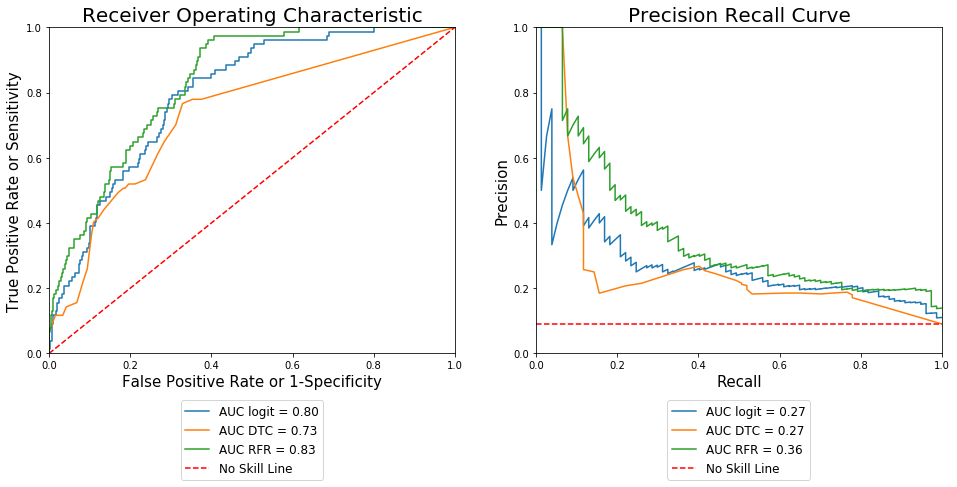

In [59]:
# Plotting AUROC Curve - Calculatae Metrics
from sklearn import metrics
def calc_aucroc_data(result):
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    f1 = metrics.f1_score(y_ACTUAL, yhat)
    ap = metrics.average_precision_score(y_ACTUAL, yhat)
    postives_ratio = round(sum(result['true_label'])/(len(result['true_label'])),2)
    return recall, precision, f1, prc_auc, postives_ratio

fpr_logit, tpr_logit, thresholds_logit, roc_auc_logit = calc_aucroc_data(results_logit)
recall_logit, precision_logit, f1_logit, prc_auc_logit, postives_ratio_logit = calc_aucpr_data(results_logit)

fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_DTC)
recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, postives_ratio_DTC = calc_aucpr_data(results_DTC)

fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_RFR)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, postives_ratio_RFR = calc_aucpr_data(results_RFR)


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})
ax1.plot(fpr_logit, tpr_logit, label = 'AUC logit = %0.2f' % roc_auc_logit)
ax1.plot(fpr_DTC, tpr_DTC, label = 'AUC DTC = %0.2f' % roc_auc_DTC)
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC RFR = %0.2f' % roc_auc_RFR)
ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})
ax2.plot(recall_logit, precision_logit, label = 'AUC logit = %.2f' % (prc_auc_logit))
ax2.plot(recall_DTC, precision_DTC, label = 'AUC DTC = %.2f' % (prc_auc_DTC))
ax2.plot(recall_RFR, precision_RFR, label = 'AUC RFR = %.2f' % (prc_auc_RFR))
positive_class_ratio = postives_ratio_logit
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)

fig.show()



In [60]:
output_path = 'output/models'

In [61]:
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [62]:
# Export Decision Tree Classifier with Pipeline
from joblib import dump
dump(classifier_DTC, output_path+'/SMOTE_DTC.joblib')

['output/models/SMOTE_DTC.joblib']

In [63]:
# Export Random Forest Classifer with Pipeline
from joblib import dump
dump(classifier_RFR, output_path+'/SMOTE_RFR.joblib')

['output/models/SMOTE_RFR.joblib']

In [64]:
# Export Random Forest Classifer with Pipeline
from joblib import dump
dump(classifier_logit, output_path+'/SMOTE_Logit.joblib')

['output/models/SMOTE_Logit.joblib']